In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random
from scipy.stats import multivariate_normal
from sklearn import preprocessing as p

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

2022-02-13 21:50:06.401400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 21:50:06.401452: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# parallelization modules 
import os
import time
import tensorflow.random as tfr
from multiprocessing import Process, Queue, SimpleQueue

In [3]:
def prior_unif():
  return tfd.Uniform(0,10)

In [4]:
def prior_out(a,b,g,k):
  a_prior = tfd.Uniform(0,10).prob(a)
  b_prior = tfd.Uniform(0,10).prob(b)
  g_prior = tfd.Uniform(0,10).prob(g)
  k_prior = tfd.Uniform(0,10).prob(k)
  return  a_prior *b_prior * g_prior*  k_prior 

In [5]:
def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [6]:
def K_h(u,h):
  return my_kernel(u/h)/h

In [7]:
def S2(y):
  quantiles= np.zeros(9)
  for i in range(9):
      quantiles[i]= np.quantile(y,0.1+0.1*i)       #quantili 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9
  return quantiles

In [8]:
def S1(y):
  return np.mean(y)

In [9]:
from scipy.spatial import distance

def distance(s_old, s_obs):
   return np.linalg.norm(s_old-s_obs)
   # return distance.mahalanobis(s_old, s_obs, iv)

      

In [10]:
def quantile_fun(a,b,g,k,z):
    y = a+b*(1+0.8*(1-np.exp(-g*z))/(1+np.exp(-g*z)))*((1+z**2)**k)*z
    return y

In [11]:
##MAXIMAL COUPLING OF THETA
def maximal_coupling(x,y):
      current_x = x
      current_y = y  
      proposed_x = current_x + tfd.Normal(0,1).sample()
      pX = sstat.norm.pdf(proposed_x,current_x,1)
      w = tfd.Uniform(0,1).sample()*pX
      qX = sstat.norm.pdf(proposed_x,current_y,1)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
      else:
          t = True
          while t == True:
                proposed_y = current_y + tfd.Normal(0,1).sample()
                qY =  sstat.norm.pdf(proposed_y,current_y,1) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY = sstat.norm.pdf(proposed_y,current_x,1)
                if w > pY :
                  t = False

          x_new = proposed_x
          y_new = proposed_y  


      return [x_new, y_new]

In [12]:
def prob(H,s_obs,s_current,a_current,s_i,a_i):   #s[i,],a[i]
  NUM = (K_h(distance(np.array(s_current), np.array(s_obs)),H)*prior_unif().prob(a_current))
  DEN = (K_h(distance(np.array(s_i),np.array(s_obs)),H)* prior_unif().prob(a_i))
  return NUM/DEN    

In [13]:
def abc_algo_single_a (N, S, y_obs,h):
    s_obs = S(y_obs)
    s1 = np.zeros((N+1,9))
    s2 = np.zeros((N+1,9))
    y1 = np.zeros(n)
    y2 = np.zeros(n)
    y1_current = np.zeros(n)
    y2_current = np.zeros(n)
    a1 = np.zeros(N+1)
    a2 = np.zeros(N+1)
    k1=0
    k2=0
    a1_0 =prior_unif().sample(1)
    a2_0 =prior_unif().sample(1)
    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y1[i]=quantile_fun(a1_0,b_0,g_0,k_0,z)
    s1_0 = S(y1)

    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y2[i]=quantile_fun(a2_0,b_0,g_0,k_0,z)
    s2_0 = S(y2)
   
    H=h
    #while K_h(mahal(np.array(s_0),np.array(s_obs)),H)<=0:
    while K_h(distance(np.array(s1_0),np.array(s_obs)),H)<=0:    
        a1_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y1[j]=quantile_fun(a1_0,b_0,g_0,k_0,z)
        s1_0 = S(y1)
   
    a1[0]=a1_0

    while K_h(distance(np.array(s2_0),np.array(s_obs)),H)<=0:    
        a2_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y2[j]=quantile_fun(a2_0,b_0,g_0,k_0,z)
        s2_0 = S(y2)
   
    a2[0]=a2_0
    

    for i in range(N):
        
        a1_current,a2_current = maximal_coupling(a1[i],a2[i])
        b_current = b_0
        g_current = g_0
        k_current = k_0      
        for j in range(n):
          z = tfd.Normal(0,1).sample() 
          y1_current[j] = quantile_fun(a1_current,b_current,g_current,k_current,z)
          y2_current[j] = quantile_fun(a2_current,b_current,g_current,k_current,z)
        s1_current = S(y1_current)
        s2_current = S(y2_current)

       
        #den_num=tfd.Normal(theta_muold,1).prob(theta_mucurrent)*tfd.Normal(theta_tauold,1).prob(theta_taucurrent)
        #den_den=tfd.Normal(theta_mucurrent,1).prob(theta_muold)*tfd.Normal(theta_taucurrent,1).prob(theta_tauold)
        
        prob1 = prob(H,s_obs,s1_current,a1_current,s1[i,],a1[i])   #s[i,],a[i]unif().prob(a[i]))
        prob2 = prob(H,s_obs,s2_current,a2_current,s2[i,],a2[i])

        acc_prob1 = min([1.,prob1])
        acc_prob2 = min([1.,prob2])
      
        u = tfd.Uniform(0,1).sample()
        if u < acc_prob1:
              a1[i+1] = a1_current
              s1[i+1,] = s1_current
              k1+=1
        else: 
              a1[i+1] = a1[i]
              s1[i+1,] = s1[i,]

        if u < acc_prob2:
              a2[i+1] = a2_current
              s2[i+1,] = s2_current
              k2+=1
        else: 
              a2[i+1] = a2[i]
              s2[i+1,] = s2[i,]

        
    return a1,a2,k1,k2

In [14]:
aobs = 3
bobs = 1
gobs = 2
kobs = 0.5
n = 100
h = 0.6
y_obs = np.zeros(n)
for i in range(n):
  z = tfd.Normal(0,1).sample() 
  y_obs[i] = quantile_fun(aobs,bobs,gobs,kobs,z)

In [15]:
g_0 =2
b_0 =1
k_0=0.5

In [16]:
test_function_h = lambda x: x

In [17]:
def time_averaged_estimator(red_chain, blue_chain, iterations, burnin, meeting_time):
    #this function calculates only the formula at point 3
    
    #first addend
    first_sum = 0
    for i in range(burnin, iterations):
        first_sum += test_function_h(red_chain[i])
    
    #second addend
    second_sum = 0
    if meeting_time-1 > burnin + 1:
        for i in range(burnin + 1, meeting_time):
            # calculing the coefficient, and the min
            coef = (1-burnin)(iterations - burnin + 1)
            if coef > 1:
                coef = 1
            second_sum += coef * (test_function_h(red_chain[i])- test_function_h(blue_chain[i]))
            
    return (1/(iterations - burnin + 1))*first_sum + second_sum

In [18]:
def parallelized_operations(
    iterations, burnin, chains_matching_tolerance, 
    q_chain, q_meeting_time, q_time_averaged_estimator, q_acc_1, q_acc_2):
    # setting a random seed - otherwise multiprocessing has the same seed and so they end up in the same chains!
    np.random.seed(int(os.getpid() * time.time()) % 123456789 )
    tfr.set_seed(int(os.getpid() * time.time()) % 123456789 )
    
    #running metropolis hastings and obtaining two chains
    red_chain, blue_chain, acc1, acc2 =  abc_algo_single_a (iterations, S2, y_obs, h)  
    #(red_chain, blue_chain) = metropolis_hastings(iterations)
    
    #get the dimensionality from one of the chains
    dimensionality = red_chain.shape[0]

    #finding the meeting time
    meeting_time = iterations + 2
    for i in range(0, iterations-2):
        if (abs(red_chain[i]-blue_chain[i]).all() < chains_matching_tolerance) & \
            (abs(red_chain[i+1]-blue_chain[i+1]).all() < chains_matching_tolerance) & \
            (abs(red_chain[i+2]-blue_chain[i+2]).all() < chains_matching_tolerance):
            meeting_time = i
            break
    
    #checking if the chains met
    if meeting_time == iterations+2:
        print('Matching did not occurred!')
        print(meeting_time)
        return
    
    #checking if the chains met before burnin
    if meeting_time >= burnin:
        print('Meeting time occurs after burnin iterations!')
        print(meeting_time)
        return
    
    time_averaged_estimation = np.empty(0)
    
    time_averaged_estimation = time_averaged_estimator(
            red_chain, 
            blue_chain, 
            iterations, burnin, meeting_time)
    
    q_chain.put( red_chain )
    q_meeting_time.put( meeting_time )
    q_time_averaged_estimator.put( time_averaged_estimation )
    q_acc_1.put(acc1)
    q_acc_2.put(acc2)
    
    return

    

In [19]:
# this returns the number of available processors
num_processes = os.cpu_count()
num_processes

# this set the number of iteration, it should be a multiple of the number of available processors
num_batches_set = 7 #16*1 #set this
num_batches = num_batches_set

# this initialize a shared memory between processors
# note of Queue(maxsize = 0)
q_chain = SimpleQueue()
q_meeting_time = SimpleQueue()
q_time_averaged_estimator = SimpleQueue()
q_acc_1 = SimpleQueue()
q_acc_2 = SimpleQueue()

In [20]:

samplings = np.empty(0)#np.empty([dimensionality, 0])
time_averaged_estimation_sum = 0
meeting_times = np.empty(0)
correct_chains = 0

acc_1 = np.empty(0)
acc_2 = np.empty(0)

iterations = 1000
burnin = 100
# coupling tolerance
chains_matching_tolerance = 1e-3



while num_batches > 0:
    
    print("There are " + str(num_batches) + " left")
    
    if num_batches >= num_processes:
        current_number_processes = num_processes
    else:
        current_number_processes = num_batches
    
    processes = []
    for batch in range(current_number_processes):
        p = Process(
            target = parallelized_operations, 
            args = (iterations, burnin, 
                    chains_matching_tolerance, 
                    q_chain, q_meeting_time, q_time_averaged_estimator, q_acc_1, q_acc_2)
        )
        processes.append(p)

    num_batches -= current_number_processes
    
    # Starting the processes in a batch
    for p in processes:
        p.start()
        time.sleep(0.1)

    # This assures that each process in the batch is complete
    for p in processes:
        p.join()

    #unfolding queues
    while not q_chain.empty():
        red_chain = q_chain.get()
        #print('lmao')
        #print(red_chain)
        samplings = np.append(
            samplings,
            red_chain[burnin :],
            axis = 0
        )

        meeting_time = q_meeting_time.get()
        time_averaged_estimation = q_time_averaged_estimator.get()
        
        if meeting_time <= burnin: #this to avoid a biased time averaged estimator
            time_averaged_estimation_sum += time_averaged_estimation
            correct_chains += 1
        
        meeting_times = np.append(
            meeting_times,
            meeting_time
        )
    
        acc_1 = np.append(acc_1, q_acc_1.get())
        acc_2 = np.append(acc_2, q_acc_2.get())
    
del q_chain, q_meeting_time, q_time_averaged_estimator,  q_acc_1, q_acc_2
print('All processes are complete!')

There are 7 left
Matching did not occurred!
1002
Matching did not occurred!
1002
Matching did not occurred!
1002
All processes are complete!


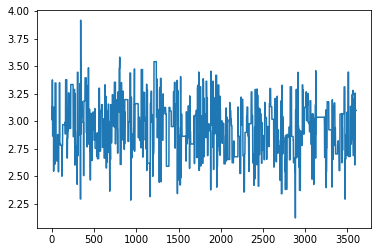

In [21]:
plt.plot(samplings)

(array([  3.,   8.,  49.,  54.,  65., 314., 339., 386., 541., 413., 476.,
        399., 201., 216.,  76.,  60.,   3.,   0.,   0.,   1.]),
 array([2.12169649, 2.21150075, 2.301305  , 2.39110926, 2.48091351,
        2.57071777, 2.66052202, 2.75032628, 2.84013053, 2.92993479,
        3.01973904, 3.1095433 , 3.19934755, 3.28915181, 3.37895606,
        3.46876032, 3.55856457, 3.64836883, 3.73817308, 3.82797733,
        3.91778159]),
 <BarContainer object of 20 artists>)

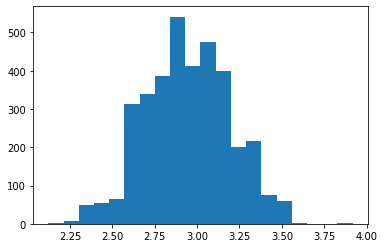

In [22]:
plt.hist(samplings, bins = 20)

In [26]:
samplings.shape

(3604,)

In [25]:
time_averaged_estimation_mean = time_averaged_estimation_sum/correct_chains
time_averaged_estimation_mean

2.941689218092825

In [27]:
acc_1

array([163., 139., 151., 148.])

In [28]:
acc_2

array([159., 138., 153., 151.])

In [29]:
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12,4)

#### Sampling plot and Histogram for all variables

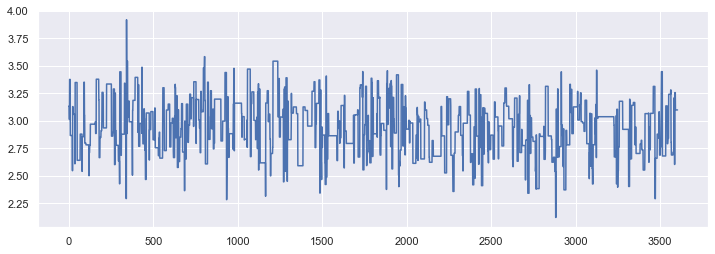

In [30]:
plt.plot(samplings)
plt.savefig('gk_single_samling.png')

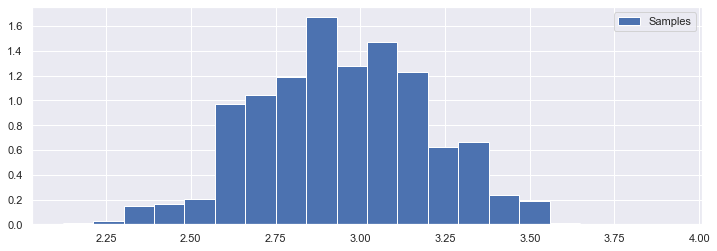

In [39]:
plt.hist(samplings, bins = 20, density = True, label = 'Samples')
plt.legend()
plt.savefig('gk_single_histogram.png')

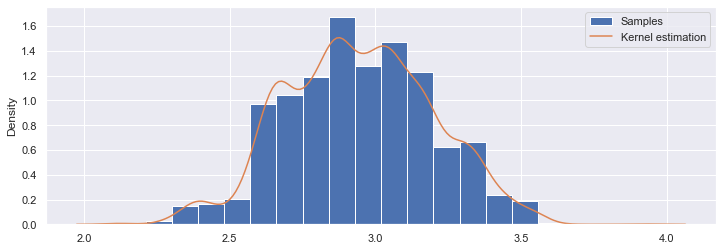

In [38]:
plt.hist(samplings, bins = 20, density = True, label='Samples')
sns.kdeplot(samplings, label='Kernel estimation')
plt.legend()
plt.savefig('gk_single_histogram_kernel.png')

In [33]:
(red_chain, blue_chain, a1, a2) = abc_algo_single_a (iterations, S2, y_obs, h)  

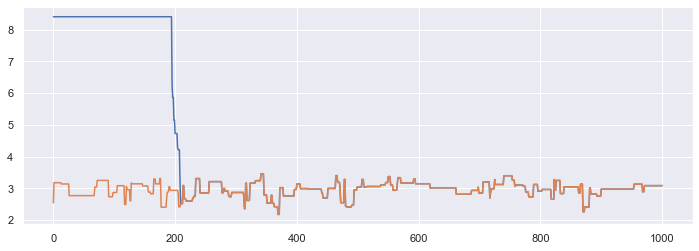

In [34]:
plt.plot(red_chain)
plt.plot(blue_chain)
plt.savefig('gk_single_chain_meeeting.png')

## For parameter b

In [ ]:
def abc_algo_single_b (N, S, y_obs,h):
    s_obs = S(y_obs)
    s1 = np.zeros((N+1,9))
    s2 = np.zeros((N+1,9))
    y1 = np.zeros(n)
    y2 = np.zeros(n)
    y1_current = np.zeros(n)
    y2_current = np.zeros(n)
    b1 = np.zeros(N+1)
    b2 = np.zeros(N+1)
    k1=0
    k2=0
    b1_0 =prior_unif().sample(1)
    b2_0 =prior_unif().sample(1)
    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y1[i]=quantile_fun(a_0,b1_0,g_0,k_0,z)
    s1_0 = S(y1)

    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y2[i]=quantile_fun(a_0,b2_0,g_0,k_0,z)
    s2_0 = S(y2)
   
    H=h
    #while K_h(mahal(np.array(s_0),np.array(s_obs)),H)<=0:
    while K_h(distance(np.array(s1_0),np.array(s_obs)),H)<=0:    
        b1_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y1[j]=quantile_fun(a_0,b1_0,g_0,k_0,z)
        s1_0 = S(y1)
   
    b1[0]=b1_0

    while K_h(distance(np.array(s2_0),np.array(s_obs)),H)<=0:    
        b2_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y2[j]=quantile_fun(a_0,b2_0,g_0,k_0,z)
        s2_0 = S(y2)
   
    b2[0]=b2_0
    

    for i in range(N):
        
        b1_current,b2_current = maximal_coupling(b1[i],b2[i])
        a_current = a_0
        g_current = g_0
        k_current = k_0      
        for j in range(n):
          z = tfd.Normal(0,1).sample() 
          y1_current[j] = quantile_fun(a_current,b1_current,g_current,k_current,z)
          y2_current[j] = quantile_fun(a_current,b2_current,g_current,k_current,z)
        s1_current = S(y1_current)
        s2_current = S(y2_current)

       
        #den_num=tfd.Normal(theta_muold,1).prob(theta_mucurrent)*tfd.Normal(theta_tauold,1).prob(theta_taucurrent)
        #den_den=tfd.Normal(theta_mucurrent,1).prob(theta_muold)*tfd.Normal(theta_taucurrent,1).prob(theta_tauold)
        
        prob1 = prob(H,s_obs,s1_current,b1_current,s1[i,],b1[i])   #s[i,],a[i]unif().prob(a[i]))
        prob2 = prob(H,s_obs,s2_current,b2_current,s2[i,],b2[i])

        acc_prob1 = min([1.,prob1])
        acc_prob2 = min([1.,prob2])
      
        u = tfd.Uniform(0,1).sample()
        if u < acc_prob1:
              b1[i+1] = b1_current
              s1[i+1,] = s1_current
              k1+=1
        else: 
              b1[i+1] = b1[i]
              s1[i+1,] = s1[i,]

        if u < acc_prob2:
              b2[i+1] = b2_current
              s2[i+1,] = s2_current
              k2+=1
        else: 
              b2[i+1] = b2[i]
              s2[i+1,] = s2[i,]

        
    return b1,b2,k1,k2

In [ ]:
aobs = 3
bobs = 1
gobs = 2
kobs = 0.5
n = 100
h = 0.6
y_obs = np.zeros(n)
for i in range(n):
  z = tfd.Normal(0,1).sample() 
  y_obs[i] = quantile_fun(aobs,bobs,gobs,kobs,z)

In [ ]:
g_0 =2
a_0 =3
k_0=0.5

## For parameter g

In [ ]:
def abc_algo_single_g (N, S, y_obs,h):
    s_obs = S(y_obs)
    s1 = np.zeros((N+1,9))
    s2 = np.zeros((N+1,9))
    y1 = np.zeros(n)
    y2 = np.zeros(n)
    y1_current = np.zeros(n)
    y2_current = np.zeros(n)
    g1 = np.zeros(N+1)
    g2 = np.zeros(N+1)
    k1=0
    k2=0
    g1_0 =prior_unif().sample(1)
    g2_0 =prior_unif().sample(1)
    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y1[i]=quantile_fun(a_0,b_0,g1_0,k_0,z)
    s1_0 = S(y1)

    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y2[i]=quantile_fun(a_0,b_0,g2_0,k_0,z)
    s2_0 = S(y2)
   
    H=h
    #while K_h(mahal(np.array(s_0),np.array(s_obs)),H)<=0:
    while K_h(distance(np.array(s1_0),np.array(s_obs)),H)<=0:    
        g1_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y1[j]=quantile_fun(a_0,b_0,g1_0,k_0,z)
        s1_0 = S(y1)
   
    g1[0]=g1_0

    while K_h(distance(np.array(s2_0),np.array(s_obs)),H)<=0:    
        g2_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y2[j]=quantile_fun(a_0,b_0,g2_0,k_0,z)
        s2_0 = S(y2)
   
    g2[0]=g2_0
    

    for i in range(N):
        
        g1_current,g2_current = maximal_coupling(g1[i],g2[i])
        a_current = a_0
        b_current = b_0
        k_current = k_0      
        for j in range(n):
          z = tfd.Normal(0,1).sample() 
          y1_current[j] = quantile_fun(a_current,b_current,g1_current,k_current,z)
          y2_current[j] = quantile_fun(a_current,b_current,g2_current,k_current,z)
        s1_current = S(y1_current)
        s2_current = S(y2_current)

       
        #den_num=tfd.Normal(theta_muold,1).prob(theta_mucurrent)*tfd.Normal(theta_tauold,1).prob(theta_taucurrent)
        #den_den=tfd.Normal(theta_mucurrent,1).prob(theta_muold)*tfd.Normal(theta_taucurrent,1).prob(theta_tauold)
        
        prob1 = prob(H,s_obs,s1_current,g1_current,s1[i,],g1[i])   #s[i,],a[i]unif().prob(a[i]))
        prob2 = prob(H,s_obs,s2_current,g2_current,s2[i,],g2[i])

        acc_prob1 = min([1.,prob1])
        acc_prob2 = min([1.,prob2])
      
        u = tfd.Uniform(0,1).sample()
        if u < acc_prob1:
              g1[i+1] = g1_current
              s1[i+1,] = s1_current
              k1+=1
        else: 
              g1[i+1] = g1[i]
              s1[i+1,] = s1[i,]

        if u < acc_prob2:
              g2[i+1] = g2_current
              s2[i+1,] = s2_current
              k2+=1
        else: 
              g2[i+1] = g2[i]
              s2[i+1,] = s2[i,]

        
    return g1,g2,k1,k2

In [ ]:
b_0 =1
a_0 =3
k_0=0.5

In [ ]:
aobs = 3
bobs = 1
gobs = 2
kobs = 0.5
n = 500

h = 0.6
y_obs_g = np.zeros(n)
for i in range(n):
  z = tfd.Normal(0,1).sample() 
  y_obs_g[i] = quantile_fun(aobs,bobs,gobs,kobs,z)

## For parameter k

In [ ]:
def abc_algo_single_k (N, S, y_obs,h):
    s_obs = S(y_obs)
    s1 = np.zeros((N+1,9))
    s2 = np.zeros((N+1,9))
    y1 = np.zeros(n)
    y2 = np.zeros(n)
    y1_current = np.zeros(n)
    y2_current = np.zeros(n)
    k1 = np.zeros(N+1)
    k2 = np.zeros(N+1)
    rate1=0
    rate2=0
    k1_0 =prior_unif().sample(1)
    k2_0 =prior_unif().sample(1)
    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y1[i]=quantile_fun(a_0,b_0,g_0,k1_0,z)
    s1_0 = S(y1)

    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y2[i]=quantile_fun(a_0,b_0,g_0,k2_0,z)
    s2_0 = S(y2)
   
    H=h
    #while K_h(mahal(np.array(s_0),np.array(s_obs)),H)<=0:
    while K_h(distance(np.array(s1_0),np.array(s_obs)),H)<=0:    
        k1_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y1[j]=quantile_fun(a_0,b_0,g_0,k1_0,z)
        s1_0 = S(y1)
   
    k1[0]=k1_0

    while K_h(distance(np.array(s2_0),np.array(s_obs)),H)<=0:    
        k2_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y2[j]=quantile_fun(a_0,b_0,g_0,k2_0,z)
        s2_0 = S(y2)
   
    k2[0]=k2_0
    

    for i in range(N):
        
        k1_current,k2_current = maximal_coupling(k1[i],k2[i])
        a_current = a_0
        b_current = b_0
        g_current = g_0      
        for j in range(n):
          z = tfd.Normal(0,1).sample() 
          y1_current[j] = quantile_fun(a_current,b_current,g_current,k1_current,z)
          y2_current[j] = quantile_fun(a_current,b_current,g_current,k2_current,z)
        s1_current = S(y1_current)
        s2_current = S(y2_current)

       
        #den_num=tfd.Normal(theta_muold,1).prob(theta_mucurrent)*tfd.Normal(theta_tauold,1).prob(theta_taucurrent)
        #den_den=tfd.Normal(theta_mucurrent,1).prob(theta_muold)*tfd.Normal(theta_taucurrent,1).prob(theta_tauold)
        
        prob1 = prob(H,s_obs,s1_current,k1_current,s1[i,],k1[i])   #s[i,],a[i]unif().prob(a[i]))
        prob2 = prob(H,s_obs,s2_current,k2_current,s2[i,],k2[i])

        acc_prob1 = min([1.,prob1])
        acc_prob2 = min([1.,prob2])
      
        u = tfd.Uniform(0,1).sample()
        if u < acc_prob1:
              k1[i+1] = k1_current
              s1[i+1,] = s1_current
              rate1+=1
        else: 
              k1[i+1] = k1[i]
              s1[i+1,] = s1[i,]

        if u < acc_prob2:
              k2[i+1] = k2_current
              s2[i+1,] = s2_current
              rate2+=1
        else: 
              k2[i+1] = k2[i]
              s2[i+1,] = s2[i,]

        
    return k1,k2, rate1, rate2

In [ ]:
b_0 =1
a_0 =3
g_0=2

h = 0.3